In [1]:
##########################
###Package dependencies###
##########################
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

In [2]:
#################
###Data Helper###
#################

def subsample(df, pct=0.9):
    N = len(df)
    indexer = np.sort(np.random.permutation(N)[:int(pct*N)])
    return df.loc[indexer,]

def getparty(politician):
    global df
    return df.loc[df['politician'] == politician, 'party'].iloc[0]

def getText(politician, match_type):
    global df
    return df[(df['politician'] == politician) & (df['match_type'] == match_type)]['entity_text']

def savedf(df, name):
    df.to_csv(outputpath + name + '.csv', sep=';')

######################
###Data Preparation###
######################
def preparedata(dforiginal):
    #Subsample to reduce amount of data
    df = subsample(dforiginal, 1)

    #format of dates, make date the index
    df["date"] = df["date"].astype("datetime64[ns]")
    df["startdate"] = df["startdate"].astype("datetime64[ns]")
    df["enddate"] = df["enddate"].astype("datetime64[ns]")
    df = df.sort_values(ascending=False, by=['date'])
    df["index"] = df["date"]
    df = df.set_index('index')
    df.levenshtein = df.levenshtein.replace('NaN', -1)
    df.levenshtein = df.levenshtein.astype('int64')
    df.party = df.party.replace('Bündnis 90/Die Grünen', 'Die Grünen')

    #Introduce date as an integer in order to perform regressions/correlations later
    df['datetimedelta'] = pd.to_timedelta(df['date'])
    df['datetimedelta'] = df['datetimedelta'] - df.datetimedelta.min()
    df["datetimedelta"] = df["datetimedelta"].astype("int")/(3600*24*1000000000)

    #Introduce categorical sentiment
    bins = [-1.000000001, -0.000000001, 0.000000001, 1.000000001]
    group_names = ['negative','neutral','positive']
    df['sentimentcategory'] = pd.cut(df['sentiment'], bins, labels=group_names)

    #Remove www.<>.de from newspapers
    df["newspaper_domain"] = df["newspaper"]
    newspapernames = [['www.afdkompakt.de','AfDkompakt'],
                        ['www.bayernkurier.de','Bayernkurier'],
                        ['www.bild.de','Bild'],
                        ['www.der-postillon.com','Der-Postillon'],
                        ['www.faz.net','FAZ'],
                        ['www.focus.de','Focus'],
                        ['www.fr.de','FR'],
                        ['www.gruene.de','Gruene.de'],
                        ['www.handelsblatt.de','Handelsblatt'],
                        ['www.huffingtonpost.de','Huffingtonpost'],
                        ['www.jungefreiheit.de','JungeFreiheit'],
                        ['www.jungewelt.de','JungeWelt'],
                        ['www.n-tv.de','N-TV'],
                        ['www.national-zeitung.de','National-Zeitung'],
                        ['www.neues-deutschland.de','Neues-Deutschland'],
                        ['www.spiegel.de','Spiegel'],
                        ['www.stern.de','Stern'],
                        ['www.sueddeutsche.de','Sueddeutsche'],
                        ['www.tagesschau.de','Tagesschau'],
                        ['www.tagesspiegel.de','Tagesspiegel'],
                        ['www.taz.de','TAZ'],
                        ['www.unsere-zeit.de','Unsere-Zeit'],
                        ['www.vorwaerts.de','Vorwaerts'],
                        ['www.welt.de','Welt'],
                        ['www.zeit.de','Zeit']]
    for paper in newspapernames:
        df.newspaper = df.newspaper.replace(paper[0], paper[1])
    return df

###################################
###Correction for newspaper bias###
###################################
def controlbias(df):
    #mean sentiment for each newspaper deviates depending on newspaper
    #optionally this can be controlled  
    df['sentimentoriginal'] = df.sentiment
    meandf = df.groupby(['newspaper'])['sentimentoriginal'].mean().sort_values()
    display(meandf)
    meanmean = meandf.mean()
    display(meanmean)
    newspmeancorr = meandf-meanmean
    display(newspmeancorr)
    withoutbias = meandf - newspmeancorr

    df['sentimentcorr'] = 0
    for newsp in newspmeancorr.index.tolist():
        df.sentimentcorr[df.newspaper == newsp] = df.sentiment[df.newspaper == newsp] - newspmeancorr[newsp]
    
    #mean sentiment for each PARTY deviates
    #optionally this can be controlled for by using sentimentcorrparty
    meandf = df.groupby(['party'])['sentimentoriginal'].mean().sort_values()
    meanmean = meandf.mean()
    display(meanmean)
    partymeancorr = meandf-meanmean
    display(partymeancorr)
    withoutbias = meandf - partymeancorr

    df['sentimentcorrparty'] = 0
    for part in partymeancorr.index.tolist():
        df.sentimentcorrparty[df.party == part] = df.sentimentoriginal[df.party == part] - partymeancorr[part]

    #Use df.sentiment as placeholder which can be switched from original to controlled versions
    df.sentiment = df.sentimentcorr

    return df

In [4]:
#######################
###Import Sentiments###
#######################

dforiginal = pd.read_csv('input/preprocessedsentiments.csv', sep=';')
df = preparedata(dforiginal)
df = controlbias(df)
savefigures = False
savename = 'v10'
inputpath = os.getcwd() + "/Input"
outputpath = os.getcwd() + "/Output/"
display(df.head(10))

newspaper
AfDkompakt          -0.209942
JungeFreiheit       -0.197561
N-TV                -0.170067
Spiegel             -0.159688
Der-Postillon       -0.146799
Focus               -0.144474
TAZ                 -0.129665
JungeWelt           -0.124157
Stern               -0.118596
FR                  -0.117387
Welt                -0.116927
Unsere-Zeit         -0.113560
Zeit                -0.111131
Neues-Deutschland   -0.109832
Bayernkurier        -0.103897
Huffingtonpost      -0.103307
Tagesspiegel        -0.101447
Handelsblatt        -0.099642
National-Zeitung    -0.096637
Gruene.de           -0.094108
FAZ                 -0.090634
Bild                -0.089797
Tagesschau          -0.082691
Vorwaerts           -0.077270
Sueddeutsche        -0.064413
Name: sentimentoriginal, dtype: float64

-0.11894515745121936

newspaper
AfDkompakt          -0.090997
JungeFreiheit       -0.078616
N-TV                -0.051122
Spiegel             -0.040743
Der-Postillon       -0.027854
Focus               -0.025529
TAZ                 -0.010719
JungeWelt           -0.005212
Stern                0.000349
FR                   0.001559
Welt                 0.002018
Unsere-Zeit          0.005385
Zeit                 0.007814
Neues-Deutschland    0.009113
Bayernkurier         0.015048
Huffingtonpost       0.015638
Tagesspiegel         0.017498
Handelsblatt         0.019304
National-Zeitung     0.022308
Gruene.de            0.024837
FAZ                  0.028311
Bild                 0.029149
Tagesschau           0.036254
Vorwaerts            0.041675
Sueddeutsche         0.054532
Name: sentimentoriginal, dtype: float64

/Users/Julian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


-0.12759982457374655

party
NPD             -0.054691
AfD             -0.032548
fraktionslos    -0.023568
Die Linke       -0.014316
CDU              0.003242
Die Grünen       0.010432
CSU              0.015141
SPD              0.025365
FDP              0.026885
Piratenpartei    0.044059
Name: sentimentoriginal, dtype: float64

/Users/Julian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,count,date,enddate,entity_text,entity_type,levenshtein,match_type,newspaper,party,politician,...,sentiment,sentiment_id,startdate,url,datetimedelta,sentimentcategory,newspaper_domain,sentimentoriginal,sentimentcorr,sentimentcorrparty
index,,,,,,,,,,,,,,,,,,,,,
2018-04-29,3,2018-04-29,2018-04-30,Merkel,Person,7,3,Neues-Deutschland,CDU,Angela Merkel,...,-0.009113,8c31707a-e7be-4746-8ea7-1b95f9fd35ac,2018-04-29,https://www.neues-deutschland.de/artikel/10868...,481.0,neutral,www.neues-deutschland.de,0.0,-0.009113,-0.003242
2018-04-29,1,2018-04-29,2018-04-30,Ursula von der Leyen,Person,-1,2,Zeit,CDU,Ursula von der Leyen,...,-0.007814,a3651fbb-6749-4620-816e-efc30d74400f,2018-04-29,https://www.zeit.de/news/2018-04/29/von-der-le...,481.0,neutral,www.zeit.de,0.0,-0.007814,-0.003242
2018-04-29,2,2018-04-29,2018-04-30,CDU,Organization,-1,2,Zeit,CDU,CDU,...,-0.007814,77d1ecb7-a418-407d-9274-13f70905f42c,2018-04-29,https://www.zeit.de/news/2018-04/30/trump-unte...,481.0,neutral,www.zeit.de,0.0,-0.007814,-0.003242
2018-04-29,1,2018-04-29,2018-04-30,Altmaier,Person,6,3,Zeit,CDU,Peter Altmaier,...,-0.007814,112b34a0-a45d-418e-8187-4fbd5c817e93,2018-04-29,https://www.zeit.de/news/2018-04/30/trump-unte...,481.0,neutral,www.zeit.de,0.0,-0.007814,-0.003242
2018-04-29,2,2018-04-29,2018-04-30,Merkel,Person,7,4,Spiegel,CDU,Angela Merkel,...,0.040743,0621a12f-c945-4b22-9885-e41c3ed4a1c3,2018-04-29,http://www.spiegel.de/politik/deutschland/news...,481.0,neutral,www.spiegel.de,0.0,0.040743,-0.003242
2018-04-29,1,2018-04-29,2018-04-30,Jens Spahn,Person,-1,2,Spiegel,CDU,Jens Spahn,...,0.040743,ac9faa51-dd36-4236-b0b1-961993e1c5a0,2018-04-29,http://www.spiegel.de/politik/deutschland/news...,481.0,neutral,www.spiegel.de,0.0,0.040743,-0.003242
2018-04-29,1,2018-04-29,2018-04-30,Merkel,Person,7,4,Zeit,CDU,Angela Merkel,...,-0.007814,89814daa-07cc-4a43-b092-c160de14dfc0,2018-04-29,https://www.zeit.de/news/2018-04/30/trump-unte...,481.0,neutral,www.zeit.de,0.0,-0.007814,-0.003242
2018-04-29,1,2018-04-29,2018-04-30,Peter Altmaier,Person,-1,1,Zeit,CDU,Peter Altmaier,...,-0.007814,2f8e25bb-7e90-4de0-bf1b-9653a89aed1f,2018-04-29,https://www.zeit.de/news/2018-04/29/altmaier-f...,481.0,neutral,www.zeit.de,0.0,-0.007814,-0.003242
2018-04-29,3,2018-04-29,2018-04-30,Altmaier,Person,6,3,Zeit,CDU,Peter Altmaier,...,-0.007814,2cac7efc-075e-47a5-b91d-18785e714e04,2018-04-29,https://www.zeit.de/wirtschaft/2018-04/donald-...,481.0,neutral,www.zeit.de,0.0,-0.007814,-0.003242


In [5]:
###########################
###Colors German Parties###
###########################
afdcolor = [0, 157/255, 224/255, 1.] #R: 0 G: 157 B: 224
cducolor = [0, 0, 0, 1.] #R: 0 G: 0 B: 0
csucolor = [70/255, 70/255, 70/255, 1. ] #R: 5 G: 132 B: 209  #schwarz
gruenecolor = [30/255, 161/255, 45/255, 1. ] #R: 30 G: 161 B: 45
linkecolor = [202/255, 2/255, 107/255, 1] # reddish: R: 220 G: 0 B: 0   purple: #R: 202 G: 2 B: 107
parteicolor = [156/255, 17/255, 56/255, 1] #R: 156 G: 17 B: 56
fdpcolor = [254/255, 237/255, 1/255, 1] #R: 254 G: 237 B: 1
npdcolor = [146/255, 52/255, 23/255, 1] #R: 146 G: 52 B: 23
piratenparteicolor = [1, 136/255, 0, 1] #R: 255 G: 136 B: 0
spdcolor = [228/255, 0, 27/255, 1] #R: 228 G: 0 B: 27
fraktionslos = [128/255, 128/255, 128/255, 1] #R: 128 G: 128 B: 128
colors = [afdcolor, cducolor, csucolor, gruenecolor, linkecolor, fdpcolor,npdcolor, piratenparteicolor, spdcolor,fraktionslos]
colorsdf = pd.DataFrame(colors)
allp = df.party.sort_values().unique()
hexcolors = []
for row in colorsdf.iterrows():
    red = int(row[1][0]*255)
    green = int(row[1][1]*255)
    blue = int(row[1][2]*255)
    hexcolor = '#%02x%02x%02x' %  (red, green, blue)
    hexcolors.append(hexcolor)
colorsdf.index = allp
colorsdf['hex'] = hexcolors

colorsnewsdf = pd.DataFrame({'newspaper': df.newspaper.unique()})
hexcolors = []
for row in colorsnewsdf.iterrows():
    hexcolor = '#%02x%02x%02x' %  (np.random.randint(255),np.random.randint(255),np.random.randint(255))
    hexcolors.append(hexcolor)
colorsnewsdf['hex'] = hexcolors
colorsnewsdf.index = colorsnewsdf['newspaper']
colorsnewsdf = colorsnewsdf[['hex']]

In [6]:
###############
###Data Sets###
###############

#Make sets for dates, newspapers, politicians, parties
all_days = pd.date_range(df.startdate.min(), df.enddate.max(), freq='D')
allnewspapers = df.newspaper.unique()
allparties = df.party.unique()
allpoliticiannames = df.politician.unique()
allpoliticians = df.groupby(['politician']).size()
allpoliticianssentiments = df.groupby(['politician', 'sentimentcategory']).size()

filterlength = int(0.92*len(allpoliticians))
frequentpoliticians = allpoliticians.sort_values(ascending=False)[:-filterlength]
frequentpoliticianslist = frequentpoliticians.index.tolist()

################
###Dataframes###
################

#NewspaperSummary
newspapersummary = df.groupby(['newspaper'])['politician', 'response_id', 'search_term', 'sentiment_id', 'url'].nunique()

index
2018-04-29                                          Linken
2018-04-29                               israelische Linke
2018-04-29                                          Linken
2018-04-29                             Lichtenberger LINKE
2018-04-29                                          Linken
2018-04-29                                          Linken
2018-04-29                                Thüringer Linken
2018-04-29                                          linken
2018-04-29                                          Linken
2018-04-29                                          Linken
2018-04-29                                          Linken
2018-04-28                                          Linken
2018-04-28                                 hessische Linke
2018-04-28                                          linken
2018-04-28                                          Linken
2018-04-28                                     Linken-Mann
2018-04-28                                        

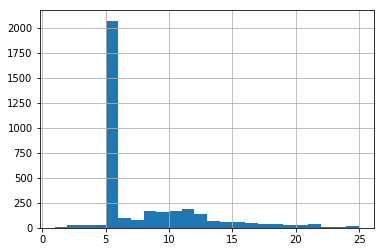

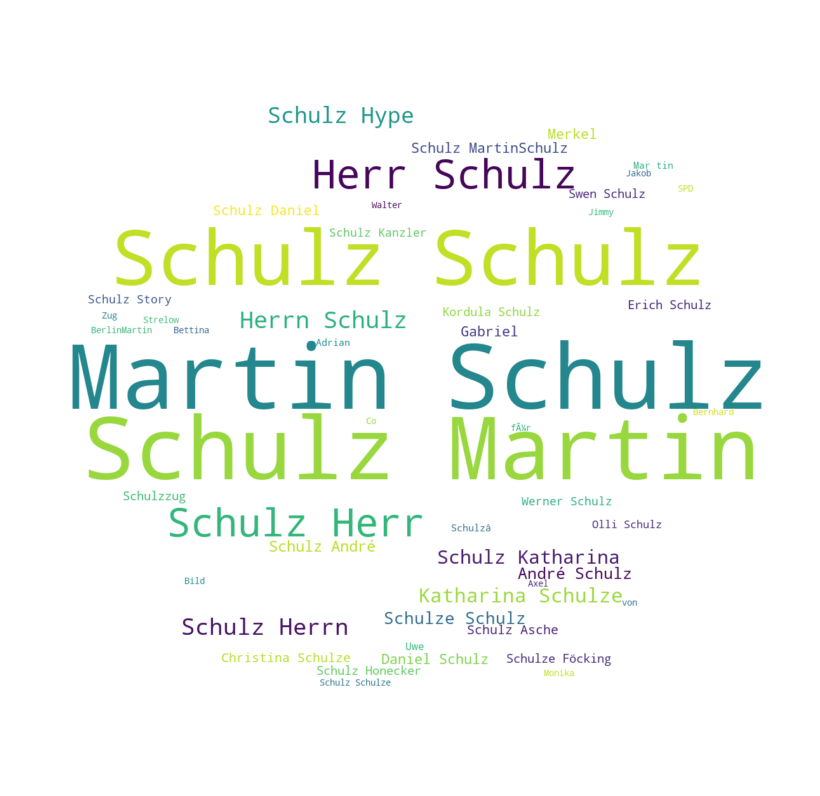

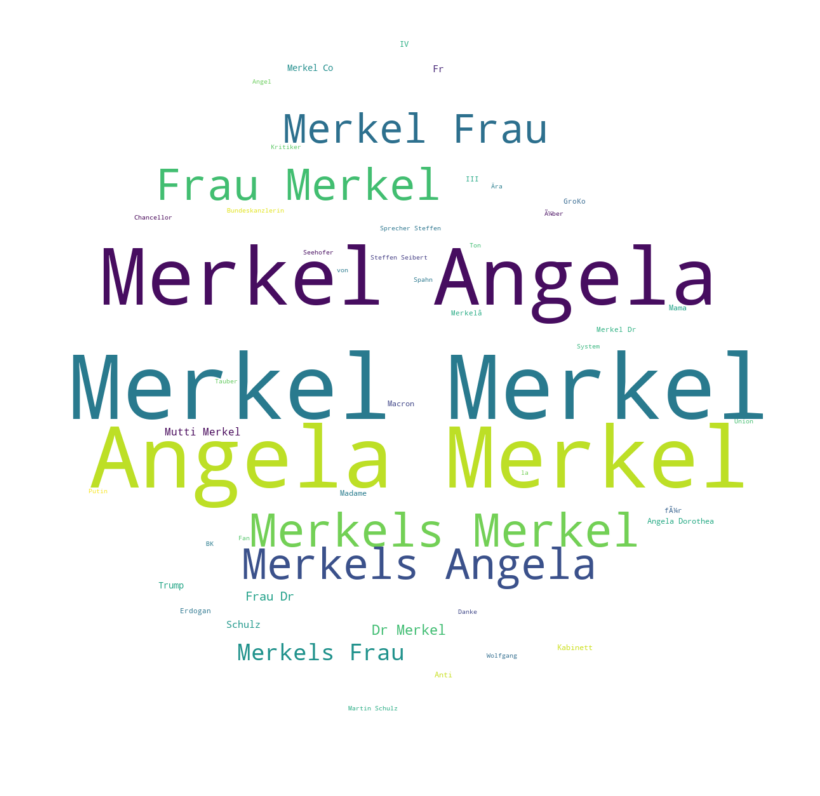

In [7]:
##############################
###Helper for manual checks###
##############################

def levhist(df, politician, match_type):
    mydf = df[(df['politician'] == politician) & (df['match_type'] == match_type)]
    mydf.levenshtein.hist(bins =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
    return mydf[mydf.levenshtein > 0].entity_text

# Libraries
from wordcloud import WordCloud
import multidict as multidict

def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        #if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
        #    continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    return fullTermsDict

def gettexts(politician):
    global df
    mydf = df[(df['politician'] == politician)]
    text = ""
    for elem in mydf.entity_text:
        if len(elem)<50:
            text = text + "\w[\w]+" + elem
    return text

def createWordcloud(politician):
    text = gettexts(politician)
    fulltermdict = getFrequencyDictForText(text)
    # Create the wordcloud object
    x, y = np.ogrid[:1200, :1200]
    mask = (x - 600) ** 2 + (y - 600) ** 2 > 560 ** 2
    mask = 255 * mask.astype(int)

    wordcloud = WordCloud(width=1200, height=1200, margin=0, background_color="white",
                          regexp="\w[\w]+", max_words=50, max_font_size=300, prefer_horizontal=1,
                          mask=mask)
    wordcloud.generate(text)
    wordcloud.to_file(outputpath + "wordcloud_" + politician + ".png")
    fig, ax = plt.subplots(figsize=(14,14))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                        wspace=None, hspace=None)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
 
display(levhist(df, 'Die Linke', 3))
createWordcloud('Martin Schulz')
createWordcloud('Angela Merkel')

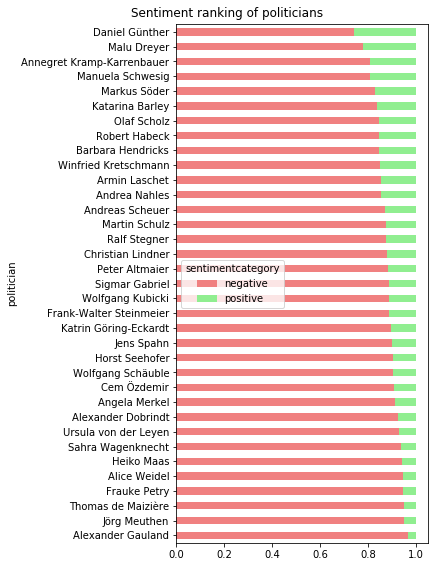

In [8]:
#############################################
###Sentiments of Politicians (Categorical)###
#############################################

filterlength = int(0.8*len(allpoliticians))
fp = allpoliticians.sort_values(ascending=False)[:-filterlength]
fpl = fp.index.tolist()
df1 = allpoliticianssentiments[fpl].unstack(level=1)
df1 = df1[['negative','positive']]
df1 = df1.drop(['AfD', 'CDU', 'CSU', 'FDP', 'Die Linke', 'NPD', 'SPD'])
totals = df1.sum(axis=1)
df2 = df1.loc[:, :].div(totals, axis=0)
df2 = df2.sort_values(ascending=True, by='positive')
df2.head(10)
fig, ax = plt.subplots(figsize=(7,int(len(df2)/4)))
fig.subplots_adjust(left=0.4, bottom=0.05, right=None, top=0.95,
                wspace=0.1, hspace=None)
myplot = df2.plot(kind='barh', stacked=True, subplots=False, ax=ax, color =['lightcoral', 'lightgreen'])
string = "barplot_" + savename + ".pdf"
fig.suptitle('Sentiment ranking of politicians')
fig.savefig(outputpath + string)

/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


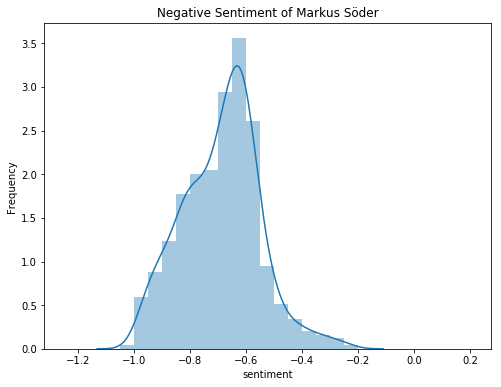

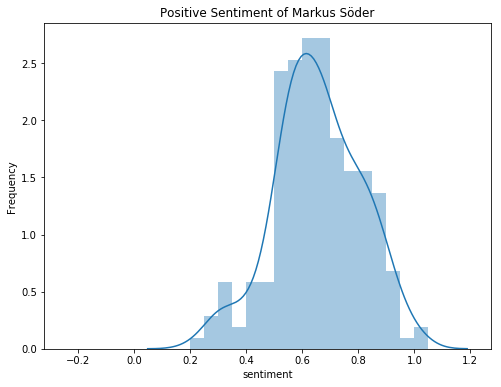

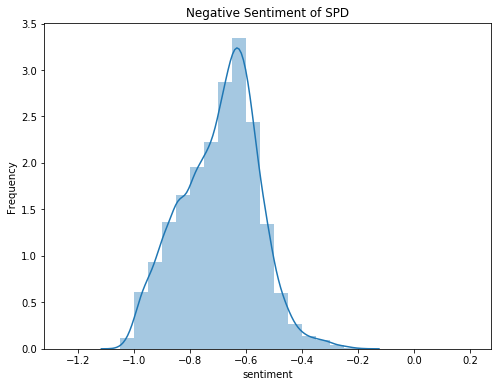

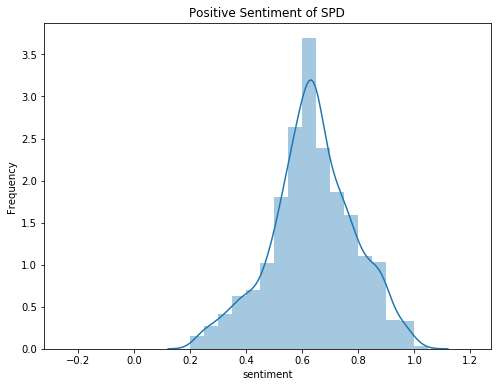

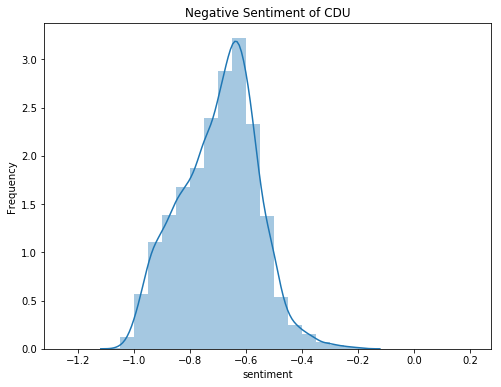

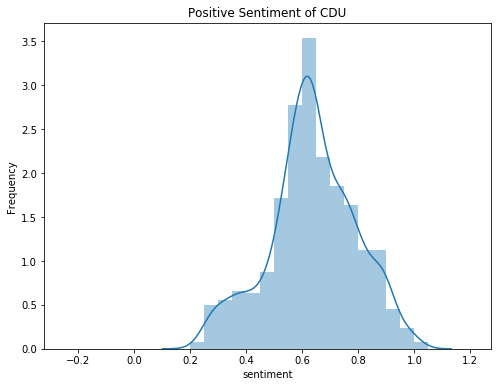

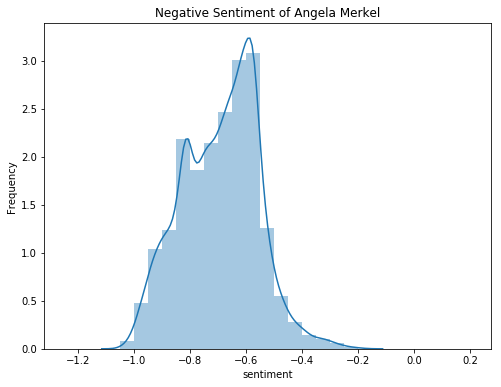

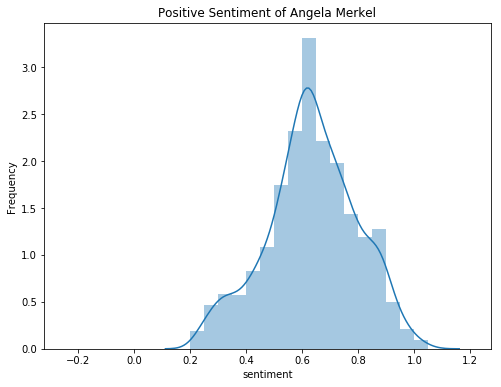

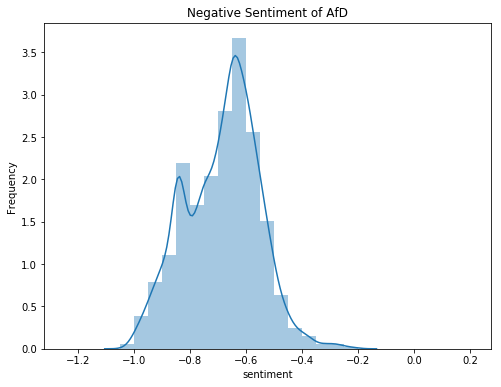

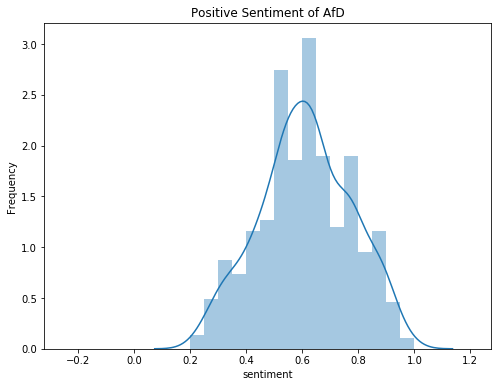

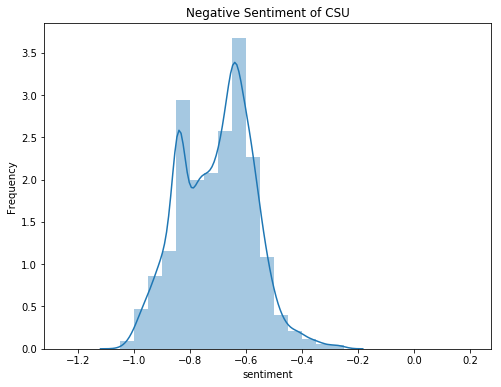

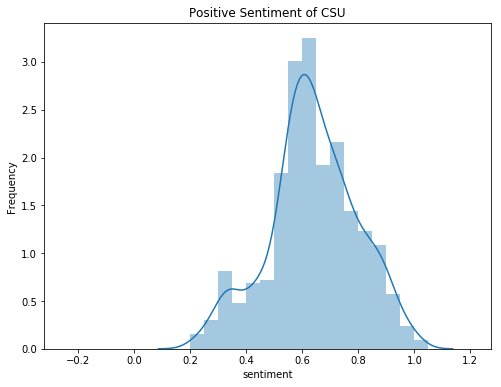

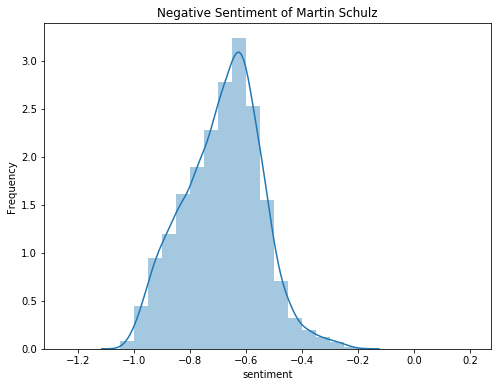

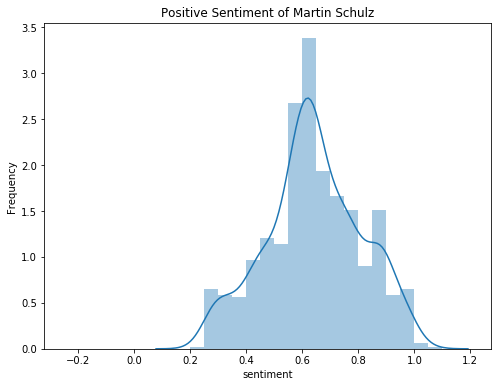

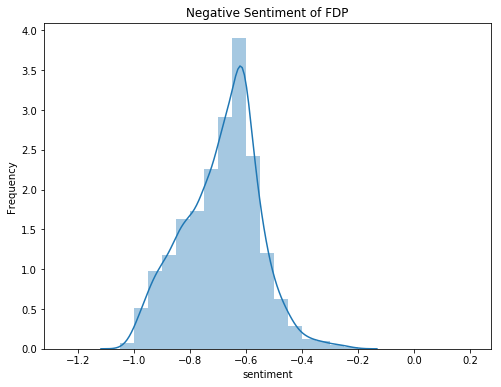

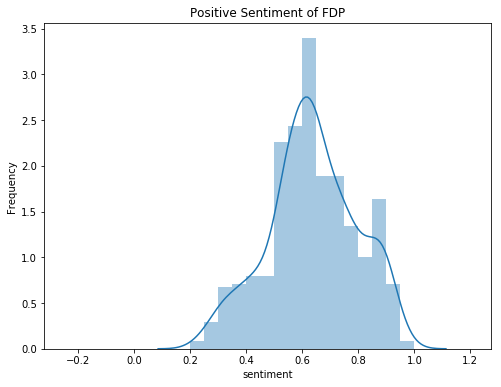

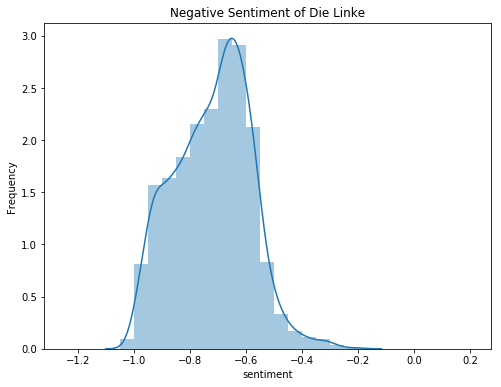

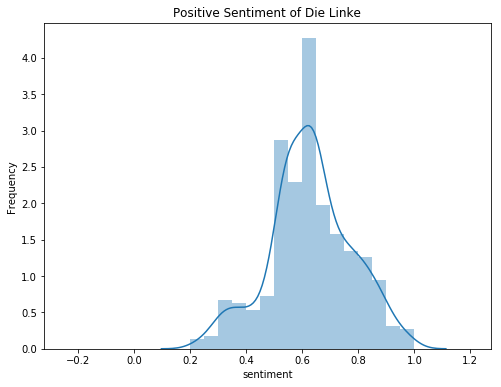

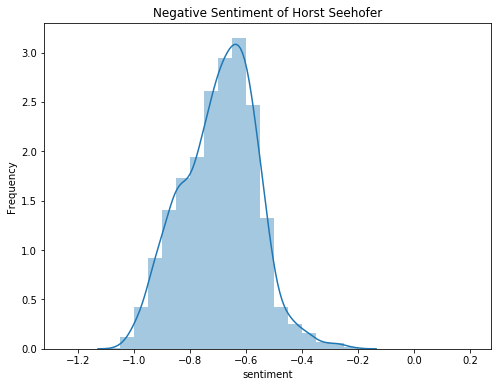

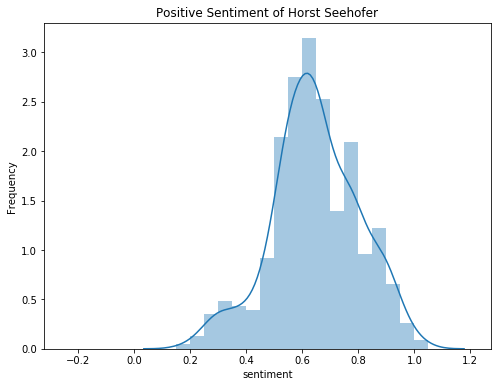

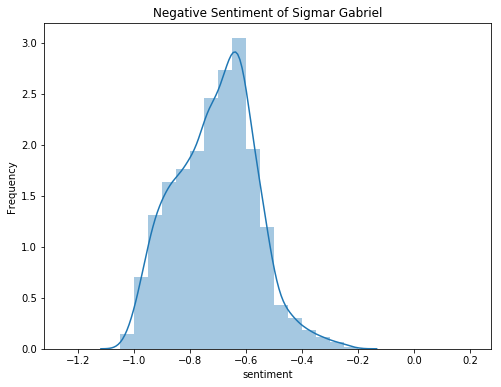

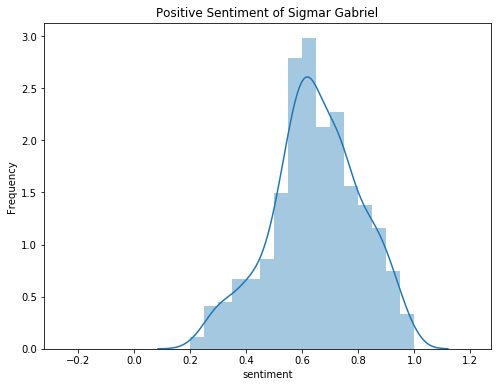

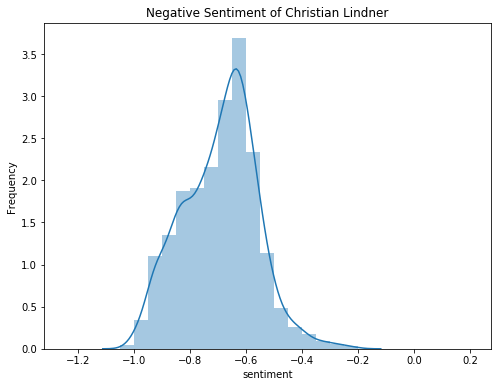

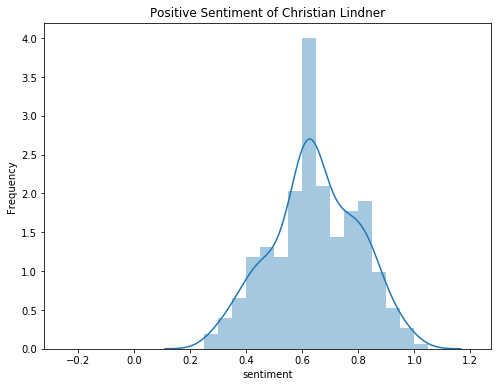

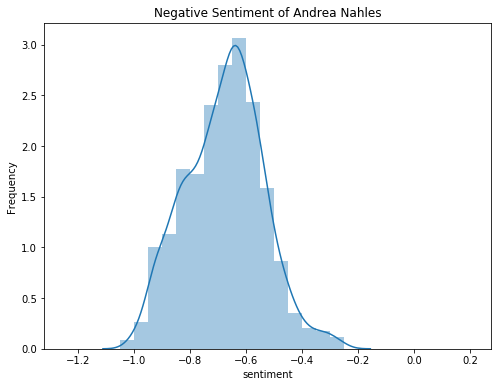

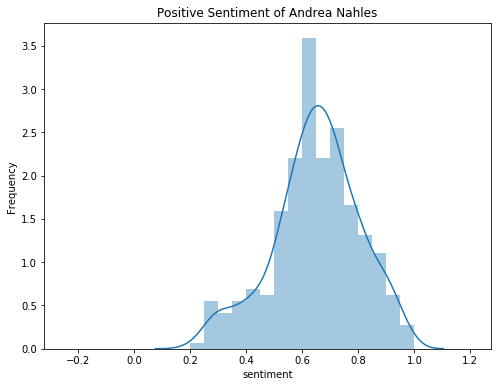

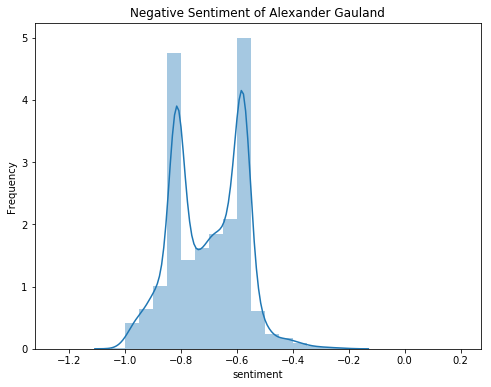

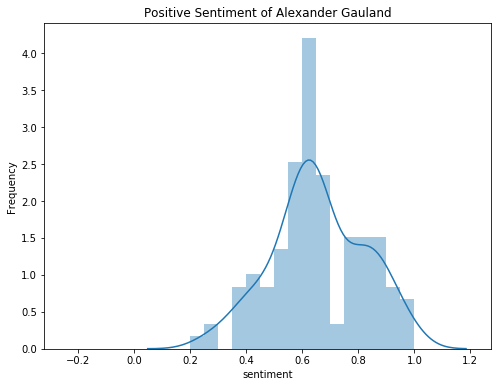

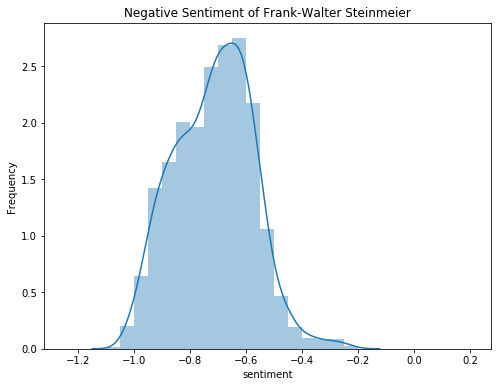

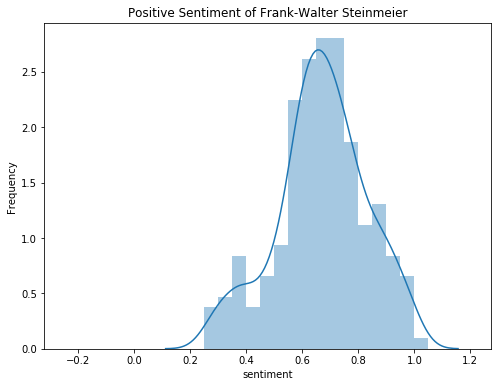

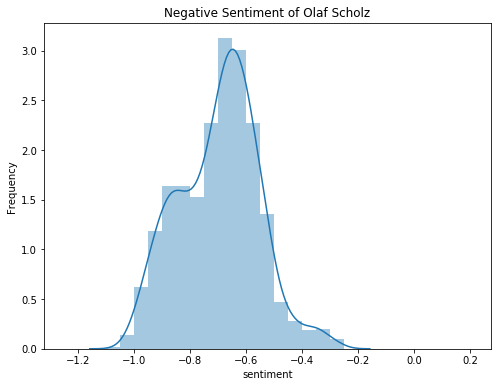

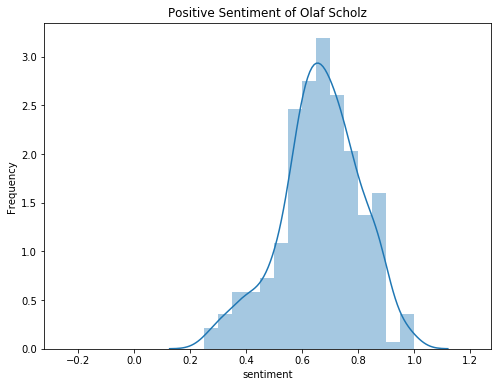

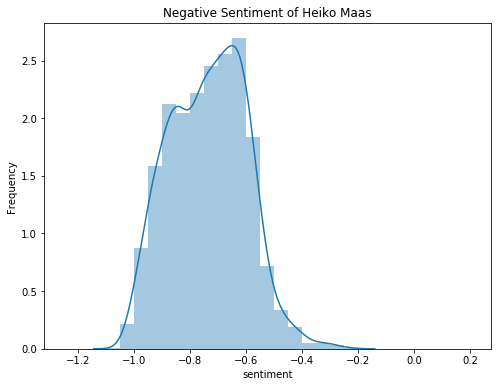

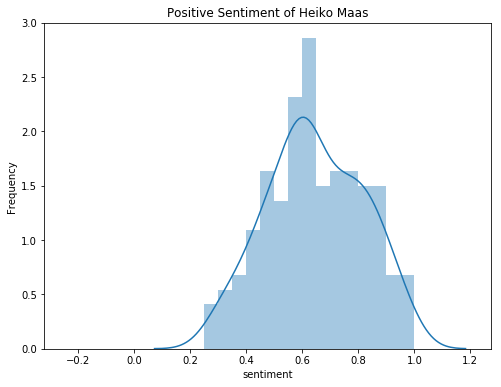

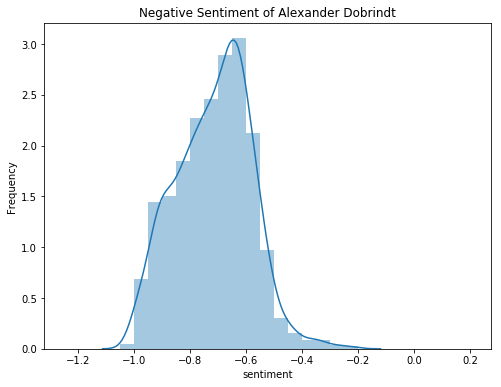

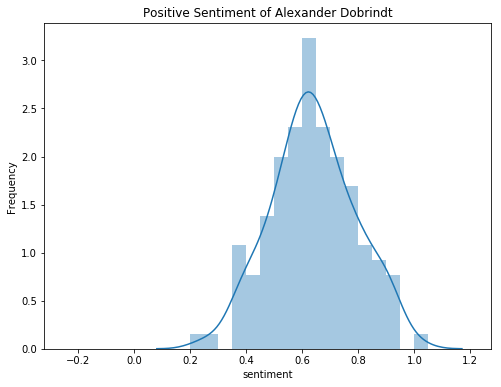

In [9]:
###########################################
###Sentiments of Politicians (Numerical)###
###########################################

def plothist(df,positive, value):
    df1 = df['sentiment']
    
    if positive:
        bins = np.arange(-0.25,1.25,0.05)
        title = 'Positive Sentiment of ' + value
        string = value + "_possentihist_" + savename + ".pdf"
    else:
        bins = np.arange(-1.25,0.25,0.05)
        title = 'Negative Sentiment of ' + value
        string = value + "_negsentihist_" + savename + ".pdf"

    fig, ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=None)
    
    ax.set_xlabel('Sentiment')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    myplot = sns.distplot(df1, bins=bins, ax=ax)
    
    if savefigures:
        plt.savefig(outputpath + string)
    else:
        plt.show()    

def sentimenthistogram(df, key, value, excludeneutral):
    if excludeneutral:
        df = df[df['sentimentcategory'] != 'neutral']

    df = df[df[key] == value]
    dfp = df[df['sentimentcategory'] == 'positive']
    dfn = df[df['sentimentcategory'] == 'negative']
    plothist(dfn,False, value)
    plothist(dfp,True, value)
   
sentimenthistogram(df,'politician', 'Markus Söder',True)
for i, row in frequentpoliticians.iteritems():
        sentimenthistogram(df, 'politician', i, True)

/Users/Julian/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


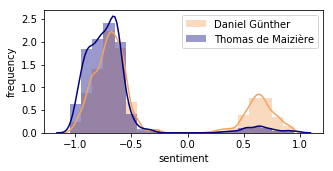

In [10]:
###########################################
###Sentiments of Politicians (Numerical)###
###########################################

pol1 = 'Thomas de Maizière'
pol2 = 'Daniel Günther'
exclude = True

dfpol1 = df[df['politician'] == pol1]
dfpol2 = df[df['politician'] == pol2]
if exclude:
    dfpol1 = dfpol1[dfpol1['sentimentcategory'] != 'neutral']
    dfpol2 = dfpol2[dfpol2['sentimentcategory'] != 'neutral']

dfpol1 = dfpol1['sentiment']
dfpol2 = dfpol2['sentiment']
dfpol1.name = pol1
dfpol2.name = pol2
fig, ax = plt.subplots(figsize=(5,2.5))
fig.subplots_adjust(left=None, bottom=0.2, right=None, top=None,
                wspace=None, hspace=None)
bins = np.arange(-1.05,1.05,0.1)  
myplot2 = sns.distplot(dfpol2, bins=bins, ax=ax, color='sandybrown', kde_kws=dict(bw=.04), label=pol2)
myplot1 = sns.distplot(dfpol1, bins=bins, ax=ax, color='navy', label=pol1)
ax.legend(loc='upper right')#, bbox_to_anchor=(1.05, 0.5), ncol=1, fancybox=True, shadow=False)

ax.set_xlabel('sentiment')
ax.set_ylabel('frequency')
    
if savefigures:
    plt.savefig(outputpath + 'histpoliticians_'+ savename + ".pdf")

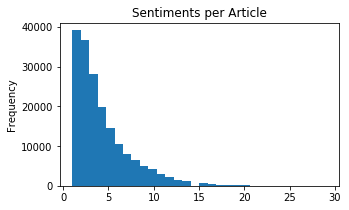

In [11]:
############################
###Histogramm Exploration###
############################

def anzhistogramm1key(df, key, title):
    #CustomizedPlots
    fig, ax = plt.subplots(figsize=(5,3))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=None)

    df1 = df.groupby(key, axis=0)['sentiment_id'].nunique()
    df1.plot(kind='hist',bins=30, ax=ax)
    string = key + "_hist_" + savename + ".pdf"
    plt.title(title)
    if savefigures:
        plt.savefig(outputpath + string)
    else:
        plt.show()
anzhistogramm1key(df,'url','Sentiments per Article')

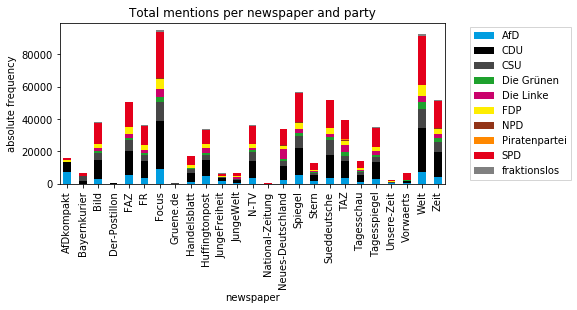

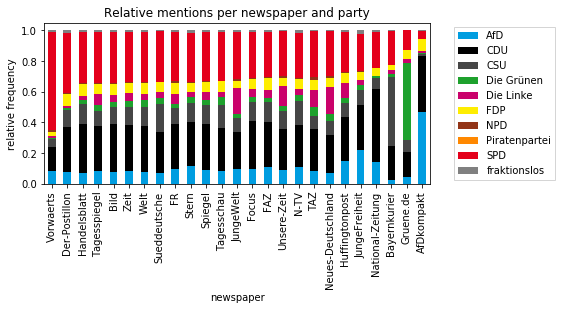

In [12]:
################
###Bar Graphs###
################

def bar2keys(df, key1, key2, titletext, crosstab, stacked, relative, size):
    #CustomizedPlots
    fig, ax = plt.subplots(figsize=size)
    fig.subplots_adjust(left=0.1, bottom=0.42, right=0.77, top=0.98,
                wspace=None, hspace=None)
    if crosstab:
        if relative:
            df1 = pd.crosstab(df[key1], df[key2], rownames=[key1], colnames=[key2])
            totals = df1.sum(axis=1)
            df2 = df1.loc[:, :].div(totals, axis=0)
            df2 = df2.sort_values(ascending=False, by=['SPD'])
            df2.plot(kind='bar', stacked=stacked, color=colors, ax=ax)
            ax.set_ylabel('relative frequency')
            string = titletext + "_" + savename + ".pdf"
        else:
            df1 = pd.crosstab(df[key1], df[key2], rownames=[key1], colnames=[key2])
            ax.set_ylabel('absolute frequency')
            df1.plot(kind='bar', stacked=stacked, color=colors, ax=ax)
            string = titletext + "_" + savename + ".pdf"

    else:
        df1 = df.groupby([key1, key2], axis=0)['sentiment_id'].nunique()
        df2 = df1.sort_values(ascending=False)
        df2.plot(kind='bar', ax=ax)
        ax.set_xlabel('mentions')
        ax.set_ylabel('relative sentiment frequency')
        string = key1 + "_grouped_" + key2 + "_hist_" + savename + ".pdf"

    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, fancybox=False, shadow=False)
    plt.title(titletext)
    if savefigures:
        plt.savefig(outputpath + string)
    else:
        plt.show()
 
bar2keys(df, 'newspaper', 'party', 'Total mentions per newspaper and party', crosstab=True, stacked=True, relative=False, size=(8,4))
bar2keys(df, 'newspaper', 'party', 'Relative mentions per newspaper and party', crosstab=True, stacked=True, relative=True, size=(8,4))

In [13]:
##################
###Event Import###
##################

def addevents(ax, partyname, politicianname, df3):
    eventsub = events[(events['party'] == partyname) | (events['politician'] == politicianname)]['news']
    up = df3.max()
    low = df3.min()
    bottom = True
    for date, text in eventsub.iteritems():
        if date in df3.index:
            ycoordinate = df3.loc[date].mean()
            if ycoordinate > df3.mean():
                vz = 1
            else:
                vz = -1
            if False:
                if bottom:
                    bottom = False
                    ycoordinate = up-0.02-0.01*np.random.randint(8, size=1)[0]
                    vz = 1
                else:
                    bottom = True
                    ycoordinate = low+0.02+0.01*np.random.randint(8, size=1)[0]
                    vz = -1
            ax.annotate(text, xy=(date, ycoordinate),  xycoords='data',
                bbox=dict(boxstyle="round", fc="sandybrown", ec="gray"),
                xytext=(0, vz*40), textcoords='offset points', ha='center',
                arrowprops=dict(arrowstyle="->"))
    return ax

def addeventlist(fig, ax, idlist, df3, alternating=True):
    eventsub = events[events.id.isin(idlist)]['newsshort']
    
    up = df3.max()
    low = df3.min()
    bottom = True
    for date, text in eventsub.iteritems():
        if date in df3.index:
            ycoordinate = df3.loc[date].mean()
            if ycoordinate > df3.mean():
                vz = 1
                distance = 5+10*np.random.randn()+80*(1-(ycoordinate-df3.mean())/(up-low))
            else:
                vz = -1
                distance = 5+10*np.random.randn()+80*(1-(df3.mean()-ycoordinate)/(up-low))
            if alternating:
                if bottom:
                    bottom = False
                    if ycoordinate > df3.mean():
                        distance = 5+10*np.random.randn()+80*(1+(ycoordinate-df3.mean())/(up-low))  
                    else:
                        distance = 5+10*np.random.randn()+80*(1-(df3.mean()-ycoordinate)/(up-low))
                    vz = -1
                else:
                    bottom = True
                    if ycoordinate > df3.mean():
                        distance = 5+10*np.random.randn()+80*(1-(ycoordinate-df3.mean())/(up-df3.mean()))  
                    else:
                        distance = 5+10*np.random.randn()+80*(1+(df3.mean()-ycoordinate)/(df3.mean()-low))
                    vz = 1
            
            ax.annotate(text, xy=(date, ycoordinate),  xycoords='data',
                bbox=dict(boxstyle="round4", fc="sandybrown", ec="black"),
                xytext=(0, vz*distance), textcoords='offset points', ha='center',
                arrowprops=dict(arrowstyle="->"))
    return ax

def addeventlistlines(fig, ax, idlist, poslist, df3, alternating=True):
    eventsub = events[events.id.isin(idlist)]['newsshort']
    counter = 0
    up = df3.max()
    low = df3.min()
    bottom = True
    for date, text in eventsub.iteritems():
        if date in df3.index:
            ycoordinate = df3.loc[date].mean()
            if ycoordinate > df3.mean():
                delta = 40
            else:
                delta = 0
            if alternating:
                if bottom:
                    bottom = False
                    delta = 0
                else:
                    bottom = True
                    delta = 40
            position = poslist[counter]
            counter = counter+1
            ax.axvline(x=date, color='navy', linestyle='--')
            ax.annotate(text, xy=(date, low),  xycoords='data',
                bbox=dict(boxstyle="round4", fc="sandybrown", ec="black"),
                xytext=(0, position), textcoords='offset points', ha='center')
    return ax
#Import list of events and create method for placing it on diagrams
events = pd.read_csv('input/eventlist.csv', sep=';')
events["date"] = pd.to_datetime(events["date"], dayfirst=True, format='%Y-%m-%d', errors='raise')
events["date"] = events["date"].astype("datetime64[ns]")
events = events.set_index('date')

##############################################
###Import external party, politcian ratings###
##############################################

ratingparties = pd.read_csv('input/ratingparties.csv', sep=';')
ratingparties["date"] = pd.to_datetime(ratingparties["date"], dayfirst=True, format='%Y-%m-%d', errors='raise')
ratingparties["date"] = ratingparties["date"].astype("datetime64[ns]")
ratingparties = ratingparties.set_index('date')

ratingpoliticians = pd.read_csv('input/ratingpoliticians.csv', sep=';')
ratingpoliticians["date"] = pd.to_datetime(ratingpoliticians["date"], dayfirst=True, format='%Y-%m-%d', errors='raise')
ratingpoliticians["date"] = ratingpoliticians["date"].astype("datetime64[ns]")
ratingpoliticians = ratingpoliticians.set_index('date')

def addrating(ax, party, politician, value):
    if party:
        series = ratingparties[value]
    if politician:
        series = ratingpoliticians[value]
    series.plot(ax=ax, secondary_y=True, label=value)
    return ax

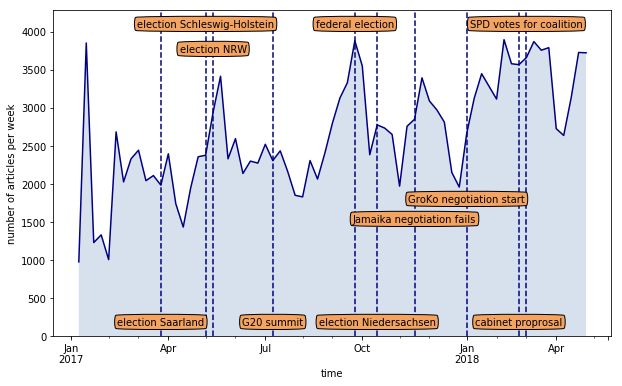

In [14]:
#####################
###Time Bar Graphs###
#####################
import matplotlib.dates as mdates

def timehist(df, key, title):
    #CustomizedPlots
    fig, ax = plt.subplots(figsize=(10,6))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=None)
    
    df1 = df[[key]]
    df1 = df1.drop_duplicates()
    df2 = df1.resample('W').agg(['count'])
    df2.columns = df2.columns.droplevel(1)
    #display(df2)
    df2.plot(ax=ax, color="navy")
    
    date = df2.index.astype('O')
    ax.fill_between(date, 0, df2[key], facecolor='lightsteelblue', alpha=0.5)

    ax = addeventlistlines(fig, ax, [25,35,45,54,73,80,88,95,109,113],[-63,235,210,-63,235,-63,40,60,235,-63], df2[key])
    ax.set_xlabel('time')
    ax.set_ylabel('number of articles per week')
    ax.set_ylim(0,1.1*df2[key].max())
    ax.legend_.remove()
    string = key + "_hist_" + savename + ".pdf"
    #plt.title(title)
    if savefigures:
        plt.savefig(outputpath + string)
    else:
        plt.show()
savename = 'v2'
savefigures = True
timehist(df, key='url', title='Articles per week')

In [15]:
#########################
###Sentiment Denoising###
#########################

import matplotlib.dates as mdates
from scipy import signal
from scipy.fftpack import fft, fftshift

def denoisesentiment(df, windowsize, key='sentiment'):
    df1 = df[key]
    df1 = df1.sort_index(ascending=True)
    
    #Fill missing days with mean
    alldays = pd.Series(df1.mean(),all_days)
    lendf1 = len(df1)
    df = alldays + df1
    print("Filled " + str(len(df)-lendf1) + " days with mean")
    
    '''
    #Tests using Changes as indicators
    dailychanges = df1.pct_change()
    #print(dailychanges)
    std_10day = dailychanges.rolling(window=3900,center=False).std()
    #std_10day = pd.rolling_std(dailychanges, 390*10)
    #std_10day.resample('B').plot()
    
    #Tests using Tukey convolution
    window = signal.tukey(datawindow)
    myarray = signal.fftconvolve(df, window, mode='same')
    myarray = myarray*df1.mean()/myarray.mean()
    df1 = pd.Series(data=myarray, index=df.index)
    display(df1)
    '''
    
    #Using sliding window to denoise signal, windowsize is dynamic depending on average weakly sentiments in time series
    datawindow = max(int(df.resample(windowsize).agg('count').mean()),3)
    df1 = df.rolling(min_periods=int(datawindow/2), center=True, win_type= 'bohman', window=datawindow, closed='both').mean()
    
    #Resampling denoised signal for each day
    df2 = df1.resample('D').agg(['sum','mean','median','std','count'])
    
    #Smoothing with a three-day sliding window
    daywindow = 3
    df3 = df2['mean'].rolling(min_periods=1, center=True, win_type= 'bohman', window=daywindow, closed='both').mean()
    return df2['mean']

Filled 250 days with mean
Filled 41 days with mean
Filled 222 days with mean
Filled 21 days with mean
Filled 13 days with mean
Filled 5 days with mean
Filled 135 days with mean
Filled 5 days with mean
Filled 120 days with mean
Filled 6 days with mean
Filled 44 days with mean
Filled 6 days with mean


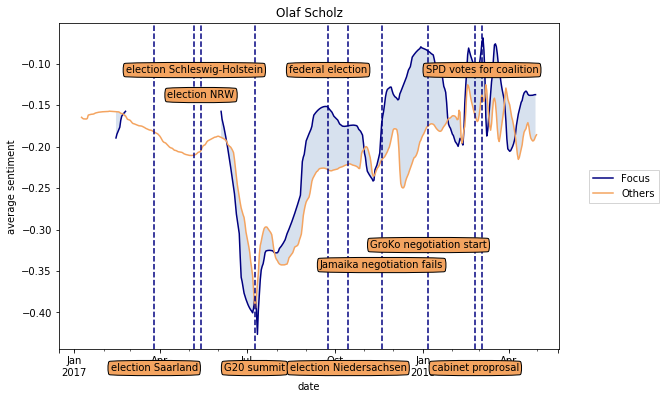

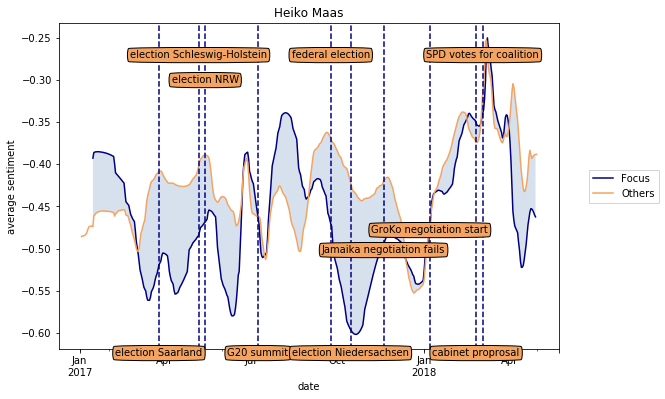

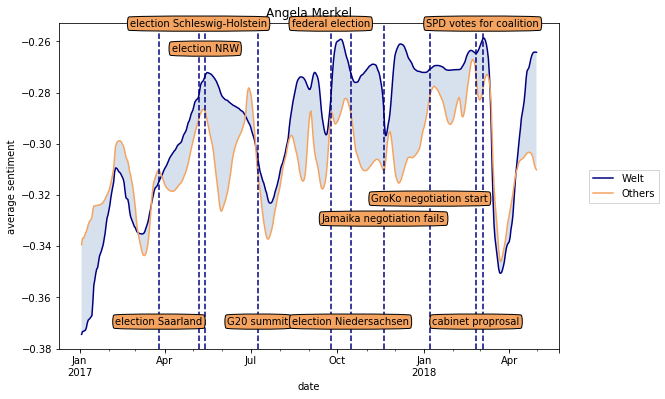

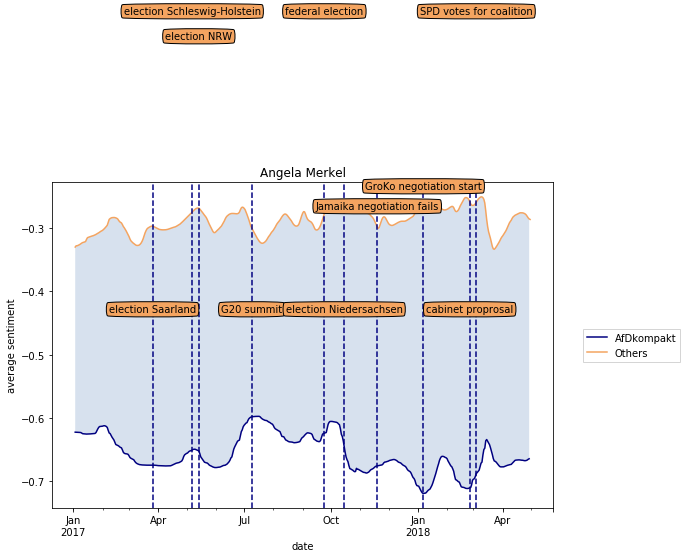

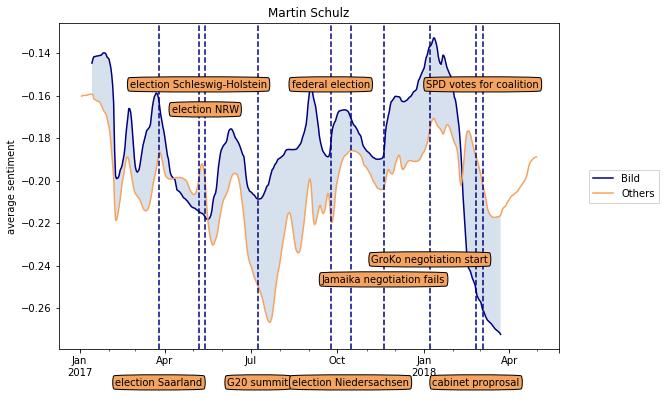

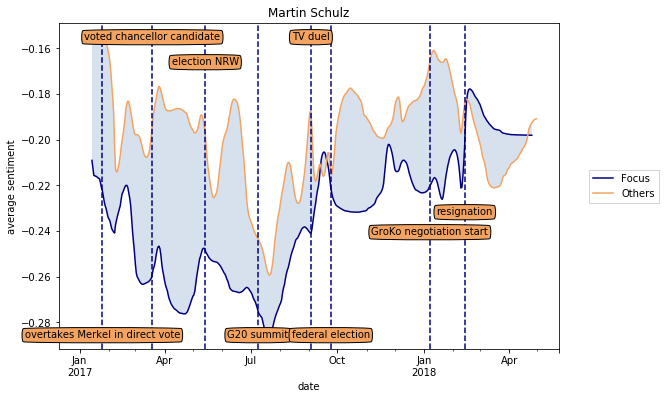

In [19]:
#########################################
###Politicians in different newspapers###
#########################################

def timesentiment(df, politician, newspaper, excludeneutral, idlist=[72]):
    if excludeneutral:
        df = df[df['sentiment'] != 0.00]
    df = df[df['politician'] == politician]
    
    newpaperdf = df[df['newspaper'] == newspaper]
    otherpapersdf = df[df['newspaper'] != newspaper]
    
    if len(newpaperdf) > 10:
        #CustomizedPlots
        fig, ax = plt.subplots(figsize=(10,6))
        fig.subplots_adjust(left=None, bottom=None, right=0.82, top=None,
                    wspace=None, hspace=None)
        newspapersentiment = denoisesentiment(newpaperdf, '2M')
        otherpaperssentiment = denoisesentiment(otherpapersdf, 'M')
        newspapersentiment.name = newspaper
        otherpaperssentiment.name = 'Others'
        newspapersentiment.plot(ax=ax, color="navy")
        otherpaperssentiment.plot(ax=ax, color="sandybrown")
        date = newspapersentiment.index.astype('O')
        ax.fill_between(date, otherpaperssentiment, newspapersentiment, facecolor='lightsteelblue', alpha=0.5)
        ax = addeventlistlines(fig, ax, idlist,poslist, otherpaperssentiment)
        ax.set_xlabel('date')
        ax.set_ylabel('average sentiment')
        string = politician + newspaper + "_timeseries_" + savename + ".pdf"
        ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, fancybox=False, shadow=False)
        plt.title(politician)
        if savefigures:
            plt.savefig(outputpath + string)
        else:
            plt.show()

idlist=[25,35,45,54,73,80,88,95,109,113]
poslist= [-63,235,210,-63,235,-63,40,60,235,-63]
timesentiment(df, 'Olaf Scholz','Focus', excludeneutral=False, idlist=idlist)
timesentiment(df, 'Heiko Maas','Focus', excludeneutral=False, idlist=idlist)
timesentiment(df, 'Angela Merkel', 'Welt', excludeneutral=False,idlist=idlist)
timesentiment(df, 'Angela Merkel', 'AfDkompakt', excludeneutral=False,idlist=idlist)
timesentiment(df, 'Martin Schulz', 'Bild', excludeneutral=False,idlist=idlist)
timesentiment(df, 'Martin Schulz', 'Focus', excludeneutral=False,idlist=[107,95,72,54,56,41,15,21])

Neues-Deutschland
Filled 17 days with mean
Zeit
Filled 7 days with mean
Spiegel
Filled 8 days with mean
Huffingtonpost
Filled 7 days with mean
FAZ
Filled 6 days with mean
Focus
Filled 6 days with mean
Stern
Filled 40 days with mean
Welt
Filled 5 days with mean
Bild
Filled 5 days with mean
FR
Filled 5 days with mean
Tagesspiegel
Filled 5 days with mean
Vorwaerts
Sueddeutsche
Filled 6 days with mean
TAZ
Filled 6 days with mean
N-TV
Filled 7 days with mean
Handelsblatt
Filled 15 days with mean
AfDkompakt
Filled 93 days with mean
Tagesschau
Filled 108 days with mean
JungeWelt
JungeFreiheit
Gruene.de
Bayernkurier
Unsere-Zeit
Der-Postillon
National-Zeitung
Filled 325 days with mean
Filled 44 days with mean
Filled 6 days with mean


NameError: name 'bildseries' is not defined

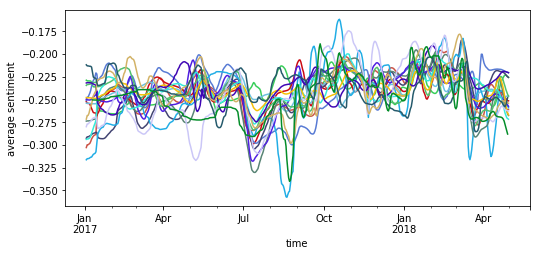

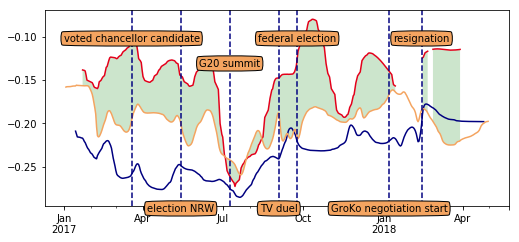

In [30]:
#############################
###Custom Time Series Plot###
#############################

def addtime(series, fig, ax, color, label): 
    series.name = label
    series.plot(ax=ax, color=color)
    return ax

def add_all_newspapers(fig, ax):
    for paper in df.newspaper.unique():
        print(paper)
        mydf = df[df['newspaper'] == paper]
        if len(mydf) > 10000:
            myseries = denoisesentiment(mydf, 'M')
            myseries.name = paper
            newscolor = [colorsnewsdf['hex'].loc[paper],paper]
            ax = addtime(myseries, fig, ax, newscolor, paper)

def add_all_sentiments(fig, ax):
    #All sentiments
    myseries = denoisesentiment(df, '3W')
    myseries.name = 'All newspapers'
    ax = addtime(myseries, fig, ax, 'navy', 'All newspapers')
    date = myseries.index.astype('O')
    #ax.legend_.remove()
    ax.set_ylim([-0.32,-0.175])
    title = 'allsentimentstime_'
    ax = addeventlistlines(fig, ax,[25,45,54,73,80,88,95,113],[-20,150,120,-20,150,30,132,-20], myseries)

def martin_schulz_vorw_bild(fig, ax):
    schulzdf = df[df['politician'] == 'Martin Schulz']
    vorwaertsdf = schulzdf[schulzdf['newspaper'] == 'Vorwaerts']
    focusdf = schulzdf[schulzdf['newspaper'] == 'Focus']
    othersdf = schulzdf[schulzdf['newspaper'] != 'Vorwaerts']
    othersdf = othersdf[othersdf['newspaper'] != 'Focus']
    vorwaertsseries = denoisesentiment(vorwaertsdf, '3M')
    focusseries = denoisesentiment(focusdf, '2M')
    othersseries = denoisesentiment(othersdf, 'M')
    vorwaertsseries.name = 'Vorwaerts'
    focusdf.name = 'Focus'
    othersseries.name = 'Other newspapers'
    ax = addtime(vorwaertsseries, fig, ax, colorsdf['hex'].loc['SPD'], label='Vorwaerts')
    ax = addtime(focusseries, fig, ax, 'navy', label='Focus')
    ax = addtime(othersseries, fig, ax, 'sandybrown', label='Other newspapers')
    ax = addeventlistlines(fig, ax,[21,41,54,56,72,95,107],[145,-25,120,-25,145,-25,145], vorwaertsseries)
    date = othersseries.index.astype('O')
    ax.fill_between(date, othersseries, vorwaertsseries, facecolor='green', alpha=0.2)
    ax.fill_between(date, othersseries, bildseries, facecolor='red', alpha=0.07)
    ax.set_ylim([-0.32,-0.05]) 
    title = 'martinschulztime_'

def angela_merkel_afd_welt(fig, ax):
    merkeldf = df[df['politician'] == 'Angela Merkel']
    afddf = merkeldf[merkeldf['newspaper'] == 'AfDkompakt']
    weltdf = merkeldf[merkeldf['newspaper'] == 'Welt']
    othersdf = merkeldf[merkeldf['newspaper'] != 'AfDkompakt']
    othersdf = othersdf[othersdf['newspaper'] != 'Welt']
    afdseries = denoisesentiment(afddf, '3M')
    weltseries = denoisesentiment(weltdf, '2M')
    othersseries = denoisesentiment(othersdf, 'M')
    afdseries.name = 'AfDkompakt'
    weltseries.name = 'Welt'
    othersseries.name = 'Other newspapers'
    ax = addtime(afdseries, fig, ax, colorsdf['hex'].loc['AfD'], 'AfDkompakt')
    ax = addtime(weltseries, fig, ax, 'navy', 'Welt')
    ax = addtime(othersseries, fig, ax, 'sandybrown', 'Other newspapers')
    ax = addeventlistlines(fig, ax,[25,45,54,56,73,88,95,113],[-10,160,-10,160,70,-10,90,160], afdseries)
    date = othersseries.index.astype('O')
    ax.fill_between(date, othersseries, weltseries, facecolor='lightsteelblue', alpha=0.5)
    ax.fill_between(date, othersseries, afdseries, facecolor='red', alpha=0.2)

    ax.set_ylim([-0.76,-0.18])      
    title = 'angelamerkeltime_'

functions = (add_all_newspapers, martin_schulz_vorw_bild, angela_merkel_afd_welt)
for afunc in functions:
    fig, ax = plt.subplots(figsize=(10,4))
    fig.subplots_adjust(left=None, bottom=0.2, right=0.77, top=None,
                        wspace=None, hspace=None)
    afunc(fig, ax)
    ax.set_xlabel('time')
    ax.set_ylabel('average sentiment')
    if savefigures:
        plt.savefig(outputpath + savename + '.pdf')
    else:
        plt.show()

Filled 10 days with mean
Filled 10 days with mean
Filled 7 days with mean
Filled 33 days with mean
Filled 6 days with mean
Filled 11 days with mean
Filled 5 days with mean
Filled 5 days with mean
Filled 5 days with mean
Filled 5 days with mean
Filled 42 days with mean
Filled 5 days with mean
Filled 5 days with mean
Filled 5 days with mean
Filled 5 days with mean


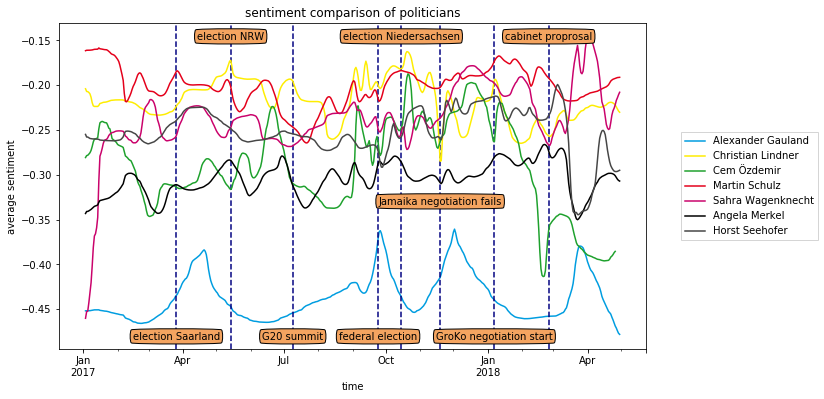

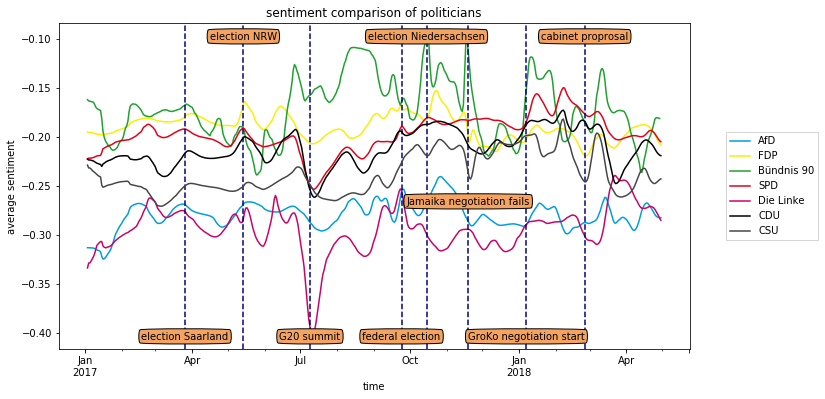

In [31]:
###########################
###Different Politicians###
###########################

def tsPol(df, politicians, excludeneutral, right):
    fig, ax = plt.subplots(figsize=(12,6))
    fig.subplots_adjust(left=0.1, bottom=None, right=right, top=None,
                        wspace=None, hspace=None)
    string = "Comp_parties_timeseries_" + savename + ".pdf"
    for pol in politicians:
        if excludeneutral:
            df1 = df[df['sentiment'] != 0.00]
        else:
            df1 = df

        df1 = df1[df1['politician'] == pol]
        
        if len(df1) > 500:
            df1sentiment = denoisesentiment(df1, 'M')
            if pol == 'Alexander Gauland':
                string = "Comp_politicians_timeseries_" + savename + ".pdf"
                df1sentiment = denoisesentiment(df1, '3M')
            df1sentiment.name = pol
            partyname = getparty(pol)
            #mycolor = colorsdf.loc(partyname)
            mycolor = [colorsdf['hex'].loc[partyname],partyname]
            df1sentiment.plot(ax=ax, color=mycolor)
            #ax = addevents(ax, getparty(pol), pol, df1sentiment)
            if pol == 'Die Linke' or pol == 'Alexander Gauland':
                ax = addeventlistlines(fig, ax, [23,41,54,73,80,88,95,113],[-5,295,-5,-5,295,130,-5,295], df1sentiment)
    ax.set_xlabel('time')
    ax.set_ylabel('average sentiment')
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, fancybox=False, shadow=False)
    plt.title('sentiment comparison of politicians')
    if savefigures:
        plt.savefig(outputpath + string)
    else:
        plt.show()
        
polarray = ['Alexander Gauland', 'Christian Lindner','Cem Özdemir','Martin Schulz','Sahra Wagenknecht','Angela Merkel','Horst Seehofer']
tsPol(df,polarray, False, 0.78)

partyarray = ['AfD', 'FDP','Bündnis 90','SPD','Die Linke','CDU','CSU']
tsPol(df,partyarray, False, 0.83)

Filled 5 days with mean
Filled 5 days with mean
Filled 5 days with mean
Filled 5 days with mean
Filled 5 days with mean
Filled 5 days with mean
Filled 5 days with mean


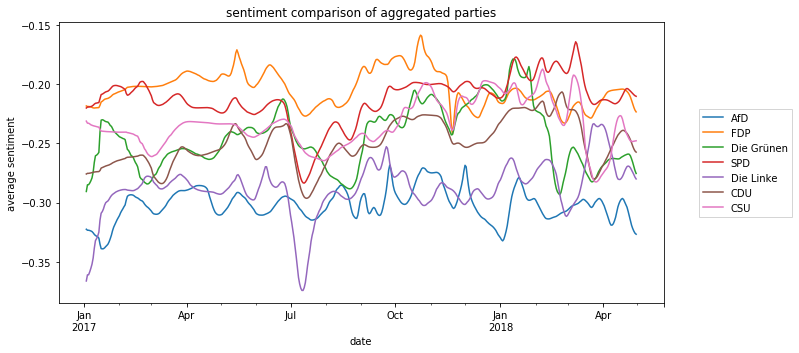

In [32]:
######################
###Party Comparison###
######################

def tsPol(df, parties, excludeneutral):
    fig, ax = plt.subplots(figsize=(12,6))
    fig.subplots_adjust(left=0.05, bottom=0.3, right=0.75, top=0.95,
                        wspace=None, hspace=None)
    
    for pa in parties:
        if excludeneutral:
            df1 = df[df['sentiment'] != 0.00]
        else:
            df1 = df

        df1 = df1[df1['party'] == pa]
        
        if len(df1) > 500:
            df1sentiment = denoisesentiment(df1, 'M')
            df1sentiment.name = pa
            df1sentiment.plot(ax=ax)
            #ax = addevents(ax, getparty(pol), pol, df1sentiment)
            
    ax.set_xlabel('date')
    ax.set_ylabel('average sentiment')
    #ax.set_ylim([-0.5,0.1])
    string = "Comp_party_timeseries_" + savename + ".pdf"
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, fancybox=False, shadow=False)
    plt.title('sentiment comparison of aggregated parties')

    if savefigures:
        plt.savefig(outputpath + string)
    else:
        plt.show()
        
partyarray = ['AfD', 'FDP','Die Grünen','SPD','Die Linke','CDU','CSU']
tsPol(df,partyarray, False)

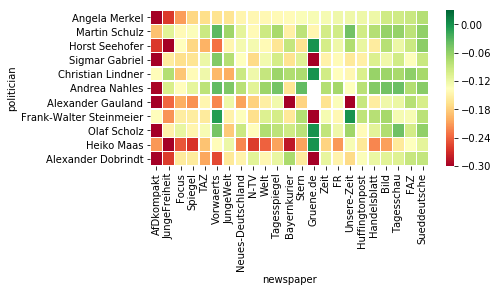

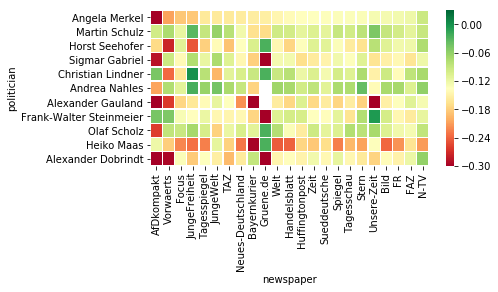

In [33]:
##############
###Heatmaps###
##############

def heatmap(df, value, aggkey, func, vmin, vmax, size, sort, title):

    df1 = pd.crosstab(df['newspaper'], df[aggkey], rownames=['newspaper'], colnames=[aggkey], values=value, aggfunc=func)
    df1.columns = df1.columns.droplevel(0)
    df1 = df1[df1.index != 'National-Zeitung']
    #df1 = df1[df1.index != 'Gruene.de']
    df1 = df1[df1.index != 'Der-Postillon']
    if aggkey == 'party':
        df1 = df1.drop(columns=['Piratenpartei', 'fraktionslos','NPD'])
        if func[0] == len:
            totals = df1.sum(axis=1)
            df1 = df1.loc[:, :].div(totals, axis=0)
    df1 = df1.sort_values(ascending=True, by=[sort])
    df1 = df1.transpose()
    #display(df1)
    if aggkey == 'politician':
        df1 = df1.loc[frequentpoliticianslist,:]    
    #display(df1)
    df1 = df1.drop(['AfD', 'CDU', 'CSU', 'FDP', 'Die Linke', 'SPD'])

    fig, ax = plt.subplots(figsize=size)
    fig.subplots_adjust(left=0.3, bottom=0.4, right=0.99, top=None,
                            wspace=None, hspace=None)
    #plt.title(title)   
    sns.heatmap(df1, linewidths=.5, ax=ax, cmap="RdYlGn", center=(vmin + vmax) / 2., vmax=vmax, vmin=vmin)
    plt.savefig(outputpath + title + savename + '.pdf')

#heatmap(df, df.sentimentoriginal,'party', [np.mean], -0.26, 0.01, (9,5), 'SPD','heatmappartiesoriginal')
#heatmap(df, df.sentimentcorr,'party', [np.mean], -0.26, 0.01, (9,5), 'SPD','heatmappartiescorr')
#heatmap(df, df.sentimentcorr,'party',[len], 0.01, 0.4, (14,5), 'Die Linke', 'Mean mentions for each party per newspaper')
heatmap(df, df.sentimentoriginal, 'politician', [np.mean], -0.3, 0.03, (7,4.5), 'Angela Merkel', 'heatmappoliticiansoriginal')
heatmap(df, df.sentimentcorr, 'politician', [np.mean], -0.3, 0.03, (7,4.5), 'Angela Merkel', 'heatmappoliticianscorr')


-117.4133412745682
-163.0
-66.0


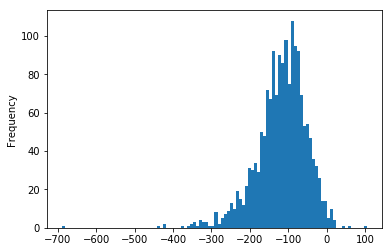

In [34]:
####################
###TreeMap Export###
####################

treemapdf = df.groupby(['party','newspaper','politician'])['sentimentoriginal'].agg(['count','mean'])
treemapdf['score'] = treemapdf['mean'] * 1000
treemapdf['score'] = treemapdf.score.astype('int64')
treemapdf['mean'] = treemapdf['mean'].round(4)
treemapdf = treemapdf[treemapdf['count'] > 30]
savedf(treemapdf, 'treemap')
treemapdf['score'].plot(kind='hist', bins=100)
print(treemapdf['score'].mean())
print(treemapdf['score'].quantile(q=0.2))
print(treemapdf['score'].quantile(q=0.8))

In [35]:
###################
###Sankey Export###
###################

sankeydf1 = df.groupby(['newspaper','party'])['sentimentoriginal'].agg(['count'])
sankeydf2 = df.groupby(['party','politician'])['sentimentoriginal'].agg(['count'])
split = 1000
sankeydf2others = sankeydf2[sankeydf2['count'] < split]
sankeydf2frequent = sankeydf2[sankeydf2['count'] > split]
print("others: "  + str(len(sankeydf2others)) + " - " + str(sankeydf2others['count'].sum()) 
      + "   frequent: "  + str(len(sankeydf2frequent)) + " - " + str(sankeydf2frequent['count'].sum()))
otherpol = sankeydf2others.groupby(['party'])['count'].agg(['sum'])
otherpol['politician'] = 'Other politicians'
otherpol = otherpol.rename(index=str, columns={"sum": "count"})
otherpol = otherpol.reset_index()
otherpol = otherpol.set_index(['party', 'politician'])
sankeydf2processed = sankeydf2frequent.append(otherpol).sortlevel()
savedf(sankeydf2processed, 'sankeydf2processed')

#Arrange Colors for Sankey
colorsinorder = []
for row in sankeydf1.iterrows():
    newp, part = row[0]  
    partcolor = [colorsdf['hex'].loc[part],part]
    if not partcolor in colorsinorder:
        colorsinorder.append(partcolor)
    subdf2 = sankeydf2frequent.loc[part]
    for row in subdf2.iterrows():
        poli = row[0]
        poli = 'Word: ' + poli
        polcolor = [colorsdf['hex'].loc[part],poli]
        if not polcolor in colorsinorder:
            colorsinorder.append(polcolor)

others: 136 - 43228   frequent: 74 - 698890


/Users/Julian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
